# Entrainment <a class='tocSkip'></a>

Thomas Schanzer z5310829  
School of Physics, UNSW  
September 2021

In this notebook, we seek to determine the effect of entrainment on a descending parcel.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Converting-theory-to-code" data-toc-modified-id="Converting-theory-to-code-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Converting theory to code</a></span><ul class="toc-item"><li><span><a href="#Step-1:-mixing-without-phase-change" data-toc-modified-id="Step-1:-mixing-without-phase-change-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Step 1: mixing without phase change</a></span></li><li><span><a href="#Step-2:-reaching-phase-equilibrium" data-toc-modified-id="Step-2:-reaching-phase-equilibrium-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Step 2: reaching phase equilibrium</a></span></li><li><span><a href="#Step-3:-descent" data-toc-modified-id="Step-3:-descent-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Step 3: descent</a></span></li></ul></li><li><span><a href="#Assembling-steps-1-3" data-toc-modified-id="Assembling-steps-1-3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Assembling steps 1-3</a></span></li><li><span><a href="#Dry-descent-testing" data-toc-modified-id="Dry-descent-testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dry descent testing</a></span><ul class="toc-item"><li><span><a href="#Changing-the-finite-difference-step-size" data-toc-modified-id="Changing-the-finite-difference-step-size-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Changing the finite difference step size</a></span></li><li><span><a href="#Changing-the-maximum-integration-step-size" data-toc-modified-id="Changing-the-maximum-integration-step-size-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Changing the maximum integration step size</a></span></li><li><span><a href="#Second-order-finite-difference-approximation" data-toc-modified-id="Second-order-finite-difference-approximation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Second order finite difference approximation</a></span></li><li><span><a href="#Dry-descent-vs.-entrainment-rate" data-toc-modified-id="Dry-descent-vs.-entrainment-rate-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Dry descent vs. entrainment rate</a></span></li><li><span><a href="#Dry-descent-testing:-summary" data-toc-modified-id="Dry-descent-testing:-summary-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Dry descent testing: summary</a></span></li></ul></li><li><span><a href="#Moist-descent-testing" data-toc-modified-id="Moist-descent-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Moist descent testing</a></span><ul class="toc-item"><li><span><a href="#Changing-the-finite-difference-step-size" data-toc-modified-id="Changing-the-finite-difference-step-size-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Changing the finite difference step size</a></span></li><li><span><a href="#Changing-the-maximum-integration-step-size" data-toc-modified-id="Changing-the-maximum-integration-step-size-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Changing the maximum integration step size</a></span></li><li><span><a href="#Second-order-finite-difference-approximation" data-toc-modified-id="Second-order-finite-difference-approximation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Second order finite difference approximation</a></span></li><li><span><a href="#Moist-descent-vs.-entrainment-rate" data-toc-modified-id="Moist-descent-vs.-entrainment-rate-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Moist descent vs. entrainment rate</a></span></li><li><span><a href="#Moist-descent-testing:-summary" data-toc-modified-id="Moist-descent-testing:-summary-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Moist descent testing: summary</a></span></li></ul></li><li><span><a href="#Zero-entrainment-case:-comparison-with-expected-values" data-toc-modified-id="Zero-entrainment-case:-comparison-with-expected-values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Zero-entrainment case: comparison with expected values</a></span><ul class="toc-item"><li><span><a href="#Dry-descent-only" data-toc-modified-id="Dry-descent-only-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Dry descent only</a></span></li><li><span><a href="#Moist-descent" data-toc-modified-id="Moist-descent-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Moist descent</a></span></li></ul></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Next steps</a></span></li></ul></div>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
import metpy.constants as const
from metpy.units import units
from metpy.units import concatenate

from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp

from os import mkdir
from os.path import exists
import sys

sys.path.append('../../scripts/')
from environment import Environment
from thermo import moist_lapse, wetbulb, theta_e, descend
from thermo import saturation_specific_humidity, temperature_change

In [2]:
fig_path = ('20210929_entrainment_figures/')
if not exists(fig_path):
    mkdir(fig_path)

In [3]:
file = '../../soundings/SYDNEY AIRPORT (94767) 12 Nov 2019 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'height', 'temperature', 'dewpoint'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
height = sounding[:,1]*units.meter
temperature = sounding[:,2]*units.celsius
dewpoint = sounding[:,3]*units.celsius
sydney = Environment(
    pressure, height, temperature, dewpoint,
    info='SYDNEY AIRPORT (94767) 12 Nov 2019 00Z', name='Sydney')

## Converting theory to code

We imagine a parcel, whose properties are denoted by a subscript P, and its environment, whose properties are denoted by a subscript E. As a result of descending through a distance $dz$, equal masses $dm$ of parcel and environmental air have been exchanged:
<img src='diagram1.png' style="width: 450px;">

The size of $dm$ is related to $dz$ by the *entrainment rate* $\lambda$, which is defined as the fraction of the parcel's mass that is exchanged per unit height:
$$ \lambda \equiv \frac{d\left(\frac{m}{m_P}\right)}{dz}. $$
Thus $dm = \lambda m_P dz$.
We now consider the parcel as a container with an imaginary partition between the original portion with mass $m_P - dm$ and the entrained portion with mass $dm$:
<img src='diagram2.png' style="width: 450px;">

The partition is then removed, and a three-step process occurs:
1. The two parts mix, conserving enthalpy and water mass without any phase changes,
2. The liquid and vapour phases of water come into equilibrium, with phase changes if necessary, and
3. The parcel descends a distance $dz$, either dry or moist adiabatically.

### Step 1: mixing without phase change
Enthalpy conservation requires that
$$
\begin{align}
    (m_P - dm) c_p T_P + dm~c_p T_E &= m_P c_p T' \\
    \Leftrightarrow \qquad T' &= \frac{(m_P - dm) c_p T_P + dm~c_p T_E}{m_P} \\
    &= T_P + \frac{dm}{m_P} (T_E - T_P) \\
    &= T_P + \lambda (T_E - T_P) dz.
\end{align}
$$
Conservation of water vapour mass (with no condensation) requires that
$$
\begin{align}
    m_{v,P} + m_{v,E} &= m_v' \\
    \Leftrightarrow \qquad (m - dm) q_P + dm~q_E &= m_P q' \\
    \Leftrightarrow \qquad q' &= q_P + \lambda (q_E - q_P) dz.
\end{align}
$$
If we use $l$ to denote a ratio of liquid mass to total mass, conservation of liquid water mass gives an identical relation
$$ l' = l_P + \lambda (l_E - l_P) dz. $$

In [4]:
def mix(parcel, environment, rate, dz):
    return parcel + rate * (environment - parcel) * dz

### Step 2: reaching phase equilibrium

Let us denote the saturation specific humidity at pressure $p$ and temperature $T$ by $q^*(p,T)$. We wish to find the final specific humidity $q''$, liquid ratio $l''$ and temperature $T''$ of the parcel once phase equilibrium is reached.

To start with, we know that any phase changes must conserve total water mass:
$$ q' + l' = q'' + l''.$$

**Case 1:** If $q' > q^*(p,T')$, water vapour must condense and the parcel will warm until it reaches its wet bulb temperature $T_W$. We will then have $q'' = q^*(p, T_W)$ and $l'' = l' + q' - q''$.

**Case 2:** If $q' \le q^*(p,T')$ and $l' > 0$, liquid water must evaporate and the parcel will cool until either
- **Case 2.1:** all liquid has evaporated, i.e., $l'' = 0$ and 
$$
    q'' = q' + l' < q^*(p,T'') = q^* \left(p, T' - \frac{Ll'}{c_p} \right)
$$
    or
- **Case 2.2:** the parcel reaches saturation. The final temperature will be the wet bulb temperature $T'' = T_W$, with $q'' = q^*(p, T_W)$ and $l'' = l' + q' - q''$.
    This is identical to Case 1, except that here $q'' > q'$.

In [87]:
def equilibrate(
        pressure, t_parcel, q_parcel, l_parcel, t_env, q_env, l_env, rate, dz):
    """
    Finds parcel properties after entrainment and phase equilibration.
    
    Args:
        pressure: Pressure during the change (constant).
        t_parcel: Initial temperature of the parcel.
        q_parcel: Initial specific humidity of the parcel.
        l_parcel: Initial ratio of liquid mass to parcel mass.
        t_env: Temperature of the environment.
        q_env: Specific humidity of the environment.
        l_env: Liquid ratio of the environment.
        rate: Entrainment rate.
        dz: Distance descended.
        
    Returns:
        A tuple containing the final parcel temperature, specific
            humidity and liquid ratio.
    """
    
    # mixing without phase change
    t_mixed = mix(t_parcel, t_env, rate, dz)
    q_mixed = mix(q_parcel, q_env, rate, dz)
    l_mixed = mix(l_parcel, l_env, rate, dz)
    q_mixed_saturated = saturation_specific_humidity(pressure, t_mixed)
    
    if q_mixed > q_mixed_saturated:
        # we need to condense water vapour
        ept = theta_e(pressure, t_mixed, q_mixed)
        t_final = wetbulb(pressure, ept, improve=True)
        q_final = saturation_specific_humidity(pressure, t_final)
        l_final = l_mixed + q_mixed - q_final
        return (t_final, q_final, l_final)
    elif q_mixed < q_mixed_saturated and l_mixed > 0:
        # we need to evaporate liquid water.
        # if all liquid evaporates:
        t_all_evap = t_mixed + temperature_change(l_mixed)
        q_all_evap_saturated = saturation_specific_humidity(
            pressure, t_all_evap)
        
        if q_mixed + l_mixed <= q_all_evap_saturated:
            return (t_all_evap, q_mixed + l_mixed, 0*units.dimensionless)
        else:
            ept = theta_e(pressure, t_mixed, q_mixed)
            t_final = wetbulb(pressure, ept, improve=True)
            q_final = saturation_specific_humidity(pressure, t_final)
            l_final = l_mixed + q_mixed - q_final
            return (t_final, q_final, l_final)
    elif q_mixed < q_mixed_saturated and l_mixed <= 0:
        # already in equilibrium, no action needed
        return (t_mixed, q_mixed, 0*units.dimensionless)
    else:
        # parcel is perfectly saturated, no action needed
        return (t_mixed, q_mixed, l_mixed)

### Step 3: descent

Once the temperature, specific humidity and liquid content of the parcel after mixing are known, we can use our descent function to determine how they change when the parcel descends a distance $dz$.

In [81]:
# moist adiabatic lapse rate - no errors apparent here
height = 5700*units.meter
dz = 1*units.meter
p_initial = sydney.pressure(height)
t_initial = -15*units.celsius
p_final = sydney.pressure(height - dz)
t, q, l = descend(
    p_final, t_initial,
    saturation_specific_humidity(p_initial, t_initial),
    1e-3, p_initial, improve=2)
(t.to(units.kelvin) - t_initial.to(units.kelvin))/dz.to(units.km)

7.208937529810555 <Unit('kelvin / kilometer')>

In [82]:
# dry adiabatic lapse rate - no errors apparent here
height = 5700*units.meter
dz = 1*units.meter
p_initial = sydney.pressure(height)
t_initial = -15*units.celsius
p_final = sydney.pressure(height - dz)
t, q, l = descend(
    p_final, t_initial,
    saturation_specific_humidity(p_initial, t_initial),
    0, p_initial, improve=2)
(t.to(units.kelvin) - t_initial.to(units.kelvin))/dz.to(units.km)

9.89110068115906 <Unit('kelvin / kilometer')>

In [86]:
const.water_heat_vaporization/const.dry_air_spec_heat_press

2489.2247336957457 <Unit('kelvin')>

## Assembling steps 1-3

We now combine the functions for the three steps. They are only valid for small, discrete steps $dz$, so the goal is to accurately find the derivatives $dT/dz$, $dq/dz$ and $dl/dz$ at any given height, so that we can integrate them numerically to find $T$, $q$ and $l$ at any height, with continuous entrainment.

We will use a first-order finite difference approximation:
$$\frac{dT}{dz} = \frac{T(z-dz) - T(z)}{-dz} + O(dz)$$
for small $dz$ (about 1 m).

In [88]:
def entrain_differential(height, state, rate, dz):
    """
    Finds the rate of change of parcel properties due to descent/entrainment.
    
    Args:
        height: Height of interest, in METRES, as number without units.
        state: Array containing parcel temperature in KELVIN,
            specific humidity and liquid ratio, all as numbers without
            units.
        rate: Entrainment rate.
        dz: Size of *downward* step, i.e. initial minus final height.
        
    Returns:
        3-tuple containing:
            Temperature change per unit height descended, in K/m
            Specific humidity change per unit height descended, in 1/m
            Liquid ratio change per unit height descended, in 1/m
    """
    
    height = height*units.meter
    t_parcel = state[0]*units.kelvin
    q_parcel = state[1]
    l_parcel = state[2]
    p_initial = sydney.pressure(height)
    p_final = sydney.pressure(height - dz)
    
    # steps 1 and 2: mixing and phase equilibration
    t_eq, q_eq, l_eq = equilibrate(
        p_initial, t_parcel, q_parcel, l_parcel, 
        sydney.temperature(height), sydney.specific_humidity(height),
        sydney.liquid_ratio(height), rate, dz)
    
    # step 3: dry or moist adiabatic descent
    t_final, q_final, l_final = descend(
        p_final, t_eq, q_eq, l_eq, p_initial, improve=3)
    
    # approximate derivatives using finite differences
    # divide by -dz to get actual rate of change with height
    dtdz = ((t_final.to(units.kelvin)
            - t_parcel.to(units.kelvin)) / -dz).m_as(units.kelvin/units.meter)
    dqdz = ((q_final - q_parcel) / -dz).m_as(1/units.meter)
    dldz = ((l_final - l_parcel) / -dz).m_as(1/units.meter)
    
    return (dtdz, dqdz, dldz)

In [89]:
def entrain_differential2(height, state, rate, dz):
    """
    Finds the rate of change of parcel properties due to descent/entrainment.
    
    Args:
        height: Height of interest, in METRES, as number without units.
        state: Array containing parcel temperature in KELVIN,
            specific humidity and liquid ratio, all as numbers without
            units.
        rate: Entrainment rate.
        dz: Size of *downward* step, i.e. initial minus final height.
        
    Returns:
        3-tuple containing:
            Temperature change per unit height descended, in K/m
            Specific humidity change per unit height descended, in 1/m
            Liquid ratio change per unit height descended, in 1/m
    """
    
    height = height*units.meter
    t_parcel = state[0]*units.kelvin
    q_parcel = state[1]
    l_parcel = state[2]
    p_initial = sydney.pressure(height)
    p_final1 = sydney.pressure(height - dz)
    p_final2 = sydney.pressure(height - 2*dz)
    
    # steps 1 and 2: mixing and phase equilibration
    t_eq1, q_eq1, l_eq1 = equilibrate(
        p_initial, t_parcel, q_parcel, l_parcel, 
        sydney.temperature(height), sydney.specific_humidity(height),
        sydney.liquid_ratio(height), rate, dz)
    t_eq2, q_eq2, l_eq2 = equilibrate(
        p_initial, t_parcel, q_parcel, l_parcel, 
        sydney.temperature(height), sydney.specific_humidity(height),
        sydney.liquid_ratio(height), rate, 2*dz)
    
    # step 3: dry or moist adiabatic descent
    t_final1, q_final1, l_final1 = descend(
        p_final1, t_eq1, q_eq1, l_eq1, p_initial, improve=3)
    t_final2, q_final2, l_final2 = descend(
        p_final2, t_eq2, q_eq2, l_eq2, p_initial, improve=3)
    
    # approximate derivatives using finite differences
    dtdz = ((3*t_parcel - 4*t_final1.to(units.kelvin)
            + t_final2.to(units.kelvin))/(2*dz)).m_as(units.kelvin/units.meter)
    dqdz = ((3*q_parcel - 4*q_final1 + q_final2)/(2*dz)).m_as(1/units.meter)
    dldz = ((3*l_parcel - 4*l_final1 + l_final2)/(2*dz)).m_as(1/units.meter)
    
    return (dtdz, dqdz, dldz)

In [90]:
def entrainment_profile(
        height, t_initial, q_initial, l_initial, rate, dz=1*units.meter,
        reference_height=None, max_step=np.inf, order=1):
    """
    Calculates parcel properties for descent with entrainment.
    
    Args:
        height: Array of heights of interest.
        t_initial: Initial parcel temperature.
        q_initial: Initial parcel specific humidity.
        l_initial: Initial parcel liquid ratio.
        rate: Entrainment rate.
        dz: Size of *downward* step for computing finite differences.
        
    Returns:
        3-tuple containing the temperature, specific humidity and
            liquid ratio arrays for the given height array.
    """
    
    height = np.atleast_1d(height)
    if reference_height is None:
        reference_height = height[0]
    t_initial = t_initial.to(units.kelvin).m

    sol = solve_ivp(
        entrain_differential if order == 1 else entrain_differential2,
        (reference_height.m_as(units.meter), height[-1].m_as(units.meter)),
        (t_initial, q_initial, l_initial), args=(rate, dz),
        t_eval=height.m_as(units.meter), max_step=max_step)
    
    t_out = sol.y[0,:]*units.kelvin
    q_out = sol.y[1,:]*units.dimensionless
    l_out = sol.y[2,:]*units.dimensionless
    
    if height.size == 1:
        t_out = t_out.item()
        q_out = q_out.item()
        l_out = l_out.item()
        
    return (t_out, q_out, l_out)

## Dry descent testing

### Changing the finite difference step size

In [38]:
height = np.arange(5000, -1, -100)*units.meter

In [183]:
%%time
t1, q1, l1 = entrainment_profile(
    height, -10*units.celsius, 1e-3, 0, 1.0/units.km, dz=1*units.m,
    max_step=500)
t2, q2, l2 = entrainment_profile(
    height, -10*units.celsius, 1e-3, 0, 1.0/units.km, dz=10*units.m,
    max_step=500)
t3, q3, l3 = entrainment_profile(
    height, -10*units.celsius, 1e-3, 0, 1.0/units.km, dz=100*units.m,
    max_step=500)

CPU times: user 1.71 s, sys: 23.5 ms, total: 1.73 s
Wall time: 1.78 s


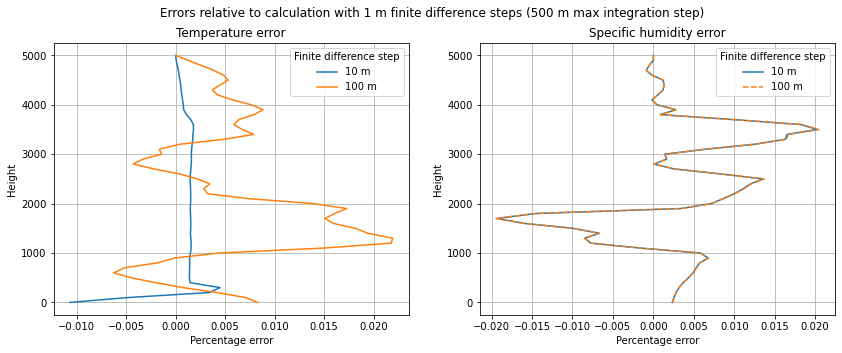

In [184]:
fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(121)
ax.plot((t1 - t2)/t1*100, height, label='10 m')
ax.plot((t1 - t3)/t1*100, height, label='100 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Finite difference step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')

ax = fig.add_subplot(122)
ax.plot((q1 - q2)/q1*100, height, label='10 m')
ax.plot((q1 - q3)/q1*100, height, '--', label='100 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Finite difference step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')

fig.suptitle('Errors relative to calculation with 1 m finite difference steps '
             '(500 m max integration step)')
fig.tight_layout
plt.show()

As long as we restrict the integration step, even to quite a large value, changing the finite difference step has almost no effect on the result.

### Changing the maximum integration step size

In [180]:
%%time
t1, q1, l1 = entrainment_profile(
    height, -10*units.celsius, 2e-3, 0, 1.0/units.km, max_step=10)

CPU times: user 19.7 s, sys: 152 ms, total: 19.9 s
Wall time: 20.6 s


In [178]:
%%time
t2, q2, l2 = entrainment_profile(
    height, -10*units.celsius, 2e-3, 0, 1.0/units.km, max_step=50)

CPU times: user 4.05 s, sys: 36.5 ms, total: 4.09 s
Wall time: 4.13 s


In [179]:
%%time
t3, q3, l3 = entrainment_profile(
    height, -10*units.celsius, 2e-3, 0, 1.0/units.km, max_step=200)

CPU times: user 1.22 s, sys: 21.2 ms, total: 1.24 s
Wall time: 1.38 s


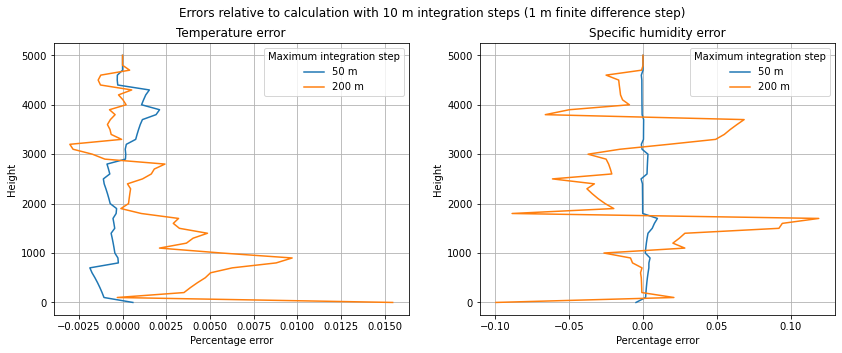

In [182]:
fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(121)
ax.plot((t1 - t2)/t1*100, height, label='50 m')
ax.plot((t1 - t3)/t1*100, height, label='200 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Maximum integration step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')

ax = fig.add_subplot(122)
ax.plot((q1 - q2)/q1*100, height, label='50 m')
ax.plot((q1 - q3)/q1*100, height, label='200 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Maximum integration step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')

fig.suptitle('Errors relative to calculation with 10 m integration steps '
             '(1 m finite difference step)')
fig.tight_layout
plt.show()

Integration step size appears to be an important factor. 200 m seems like a reasonable choice.

### Second order finite difference approximation

In [176]:
%%time
t1, q1, l1 = entrainment_profile(
    height, -10*units.celsius, 2e-3, 0, 1.0/units.km, max_step=200)

CPU times: user 1.15 s, sys: 11.6 ms, total: 1.16 s
Wall time: 1.29 s


In [175]:
%%time
t2, q2, l2 = entrainment_profile(
    height, -10*units.celsius, 2e-3, 0, 1.0/units.km, max_step=200, order=2)

CPU times: user 2.28 s, sys: 35.4 ms, total: 2.31 s
Wall time: 2.45 s


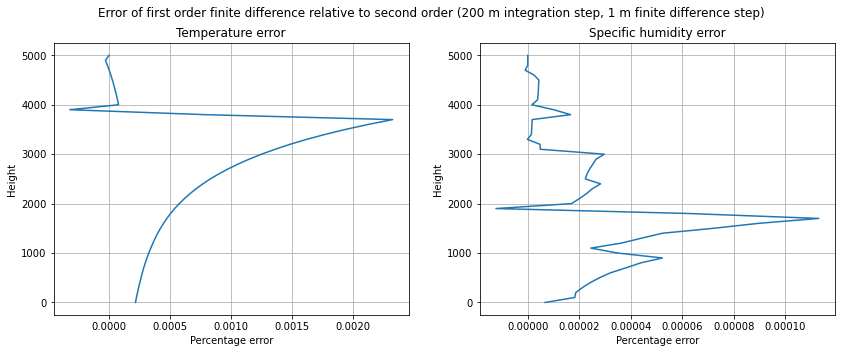

In [177]:
fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(121)
ax.plot((t2 - t1)/t2*100, height)
ax.grid()
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')

ax = fig.add_subplot(122)
ax.plot((q2 - q1)/q2*100, height)
ax.grid()
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')

fig.suptitle('Error of first order finite difference relative to second order '
             '(200 m integration step, 1 m finite difference step)')
fig.tight_layout
plt.show()

As long as the integration step is controlled, the effect of using second order finite differences is negligible.

### Dry descent vs. entrainment rate

We now test the functions on a parcel that is initially drier than the environment and contains no liquid water.

In [188]:
height = np.arange(5000, 2999, -100)*units.meter

In [193]:
%%time
t1, q1, l1 = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0, 0/units.km, max_step=200)
t2, q2, l2 = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0, 0.5/units.km, max_step=200)
t3, q3, l3 = entrainment_profile(
    height, -10*units.celsius, 5e-4, 0, 1/units.km, max_step=200)

CPU times: user 1.67 s, sys: 21.2 ms, total: 1.69 s
Wall time: 1.79 s


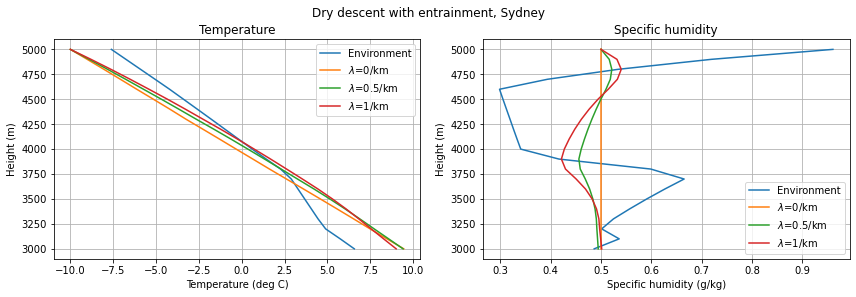

In [194]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(sydney.temperature(height), height, label='Environment')
ax.plot(t1, height, label=r'$\lambda$=0/km')
ax.plot(t2, height, label=r'$\lambda$=0.5/km')
ax.plot(t3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Temperature (deg C)',
    ylabel='Height (m)',
    title='Temperature')

ax = fig.add_subplot(122)
ax.plot(sydney.specific_humidity(height)*1e3, height, label='Environment')
ax.plot(q1*1e3, height, label=r'$\lambda$=0/km')
ax.plot(q2*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(q3*1e3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Specific humidity (g/kg)',
    ylabel='Height (m)',
    title='Specific humidity')

fig.tight_layout()
fig.suptitle('Dry descent with entrainment, Sydney', y=1.02)
# fig.savefig(
#     fig_path + 'dry_vs_entrainment_rate.png', dpi=300, facecolor='w',
#     bbox_inches='tight')
plt.show()

- The higher the entrainment rate, the more strongly the parcel is attracted to the environmental profile and the sooner it reaches equilibrium.

### Dry descent testing: summary
- As long as we restrict the integration step, even to quite a large value, changing the finite difference step has almost no effect on the result (differences are ~0.01%).
- Integration step size appears to be an important factor. 200 m seems like a reasonable choice (max 0.1% error).
- As long as the integration step is controlled, the effect of using second order finite differences is negligible.

## Moist descent testing

### Changing the finite difference step size

In [351]:
height = np.arange(5000, -1, -100)*units.meter
t_initial = -10*units.celsius
q_initial = saturation_specific_humidity(sydney.pressure(height[0]), t_initial)
l_initial = 1e-3

In [353]:
%%time
t1, q1, l1 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1.0/units.km, dz=1*units.m,
    max_step=500)
t2, q2, l2 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1.0/units.km, dz=10*units.m,
    max_step=500)
t3, q3, l3 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1.0/units.km, dz=100*units.m,
    max_step=500)

CPU times: user 1min 27s, sys: 568 ms, total: 1min 27s
Wall time: 1min 32s


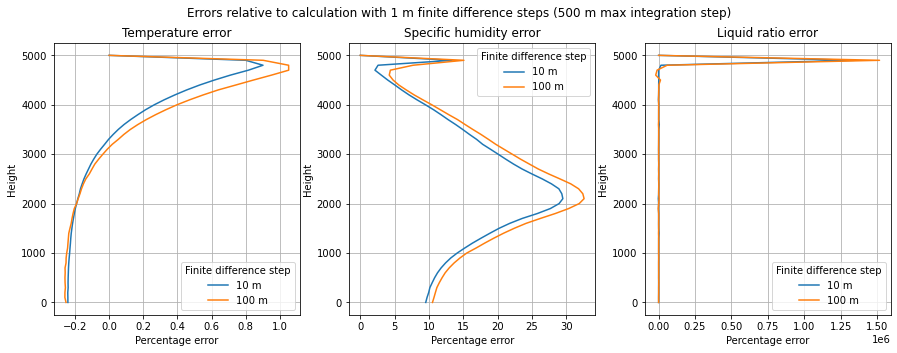

In [355]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
ax.plot((t1 - t2)/t1*100, height, label='10 m')
ax.plot((t1 - t3)/t1*100, height, label='100 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Finite difference step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')

ax = fig.add_subplot(132)
ax.plot((q1 - q2)/q1*100, height, label='10 m')
ax.plot((q1 - q3)/q1*100, height, label='100 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Finite difference step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')

ax = fig.add_subplot(133)
ax.plot((l1 - l2)/l1*100, height, label='10 m')
ax.plot((l1 - l3)/l1*100, height, label='100 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Finite difference step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Liquid ratio error')

fig.suptitle('Errors relative to calculation with 1 m finite difference steps '
             '(500 m max integration step)')
fig.tight_layout
plt.show()

The finite difference step size has a very significant effect for moist descent, especially on the specific humidity. It may be the case that the larger steps give more correct results.

### Changing the maximum integration step size

In [356]:
%%time
t1, q1, l1 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1.0/units.km, max_step=10,
    dz=30*units.meter)

CPU times: user 24.7 s, sys: 148 ms, total: 24.9 s
Wall time: 25.3 s


In [357]:
%%time
t2, q2, l2 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1.0/units.km, max_step=50,
    dz=30*units.meter)

CPU times: user 5.36 s, sys: 53.6 ms, total: 5.42 s
Wall time: 5.62 s


In [358]:
%%time
t3, q3, l3 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1.0/units.km, max_step=200,
    dz=30*units.meter)

CPU times: user 3.35 s, sys: 35.1 ms, total: 3.39 s
Wall time: 3.56 s


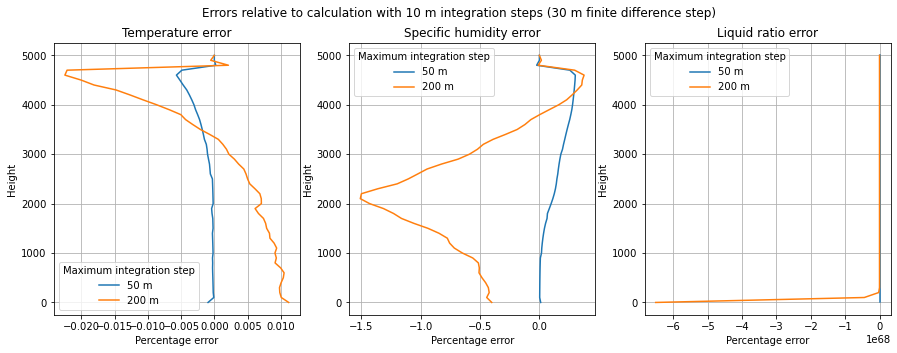

In [360]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
ax.plot((t1 - t2)/t1*100, height, label='50 m')
ax.plot((t1 - t3)/t1*100, height, label='200 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Maximum integration step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')

ax = fig.add_subplot(132)
ax.plot((q1 - q2)/q1*100, height, label='50 m')
ax.plot((q1 - q3)/q1*100, height, label='200 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Maximum integration step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')

ax = fig.add_subplot(133)
ax.plot((l1 - l2)/l1*100, height, label='50 m')
ax.plot((l1 - l3)/l1*100, height, label='200 m')
ax.grid()
lgd = ax.legend()
lgd.set_title('Maximum integration step')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Liquid ratio error')

fig.suptitle('Errors relative to calculation with 10 m integration steps '
             '(30 m finite difference step)')
fig.tight_layout
plt.show()

The size of the integration step is more important for moist descent than dry descent.

### Second order finite difference approximation

In [361]:
%%time
t1, q1, l1 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1.0/units.km, max_step=100,
    dz=30*units.meter)

CPU times: user 3.28 s, sys: 31.9 ms, total: 3.31 s
Wall time: 3.43 s


In [362]:
%%time
t2, q2, l2 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1.0/units.km, max_step=100,
    order=2, dz=30*units.meter)

CPU times: user 9.53 s, sys: 115 ms, total: 9.64 s
Wall time: 10.9 s


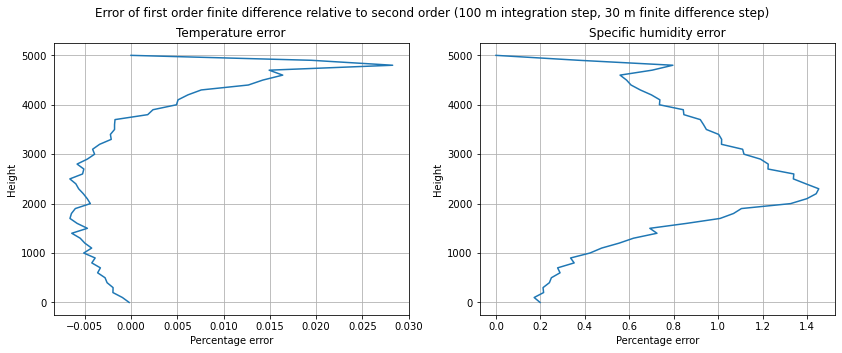

In [364]:
fig = plt.figure(figsize=(14,5))

ax = fig.add_subplot(121)
ax.plot((t2 - t1)/t2*100, height)
ax.grid()
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')

ax = fig.add_subplot(122)
ax.plot((q2 - q1)/q2*100, height)
ax.grid()
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')

fig.suptitle('Error of first order finite difference relative to second order '
             '(100 m integration step, 30 m finite difference step)')
fig.tight_layout
plt.show()

### Moist descent vs. entrainment rate

In [91]:
height = np.arange(5000, 2999, -100)*units.meter
t_initial = -10*units.celsius

q_initial = saturation_specific_humidity(sydney.pressure(height[0]), t_initial)
l_initial = 1e-3

In [98]:
t, _, _ = entrainment_profile(
    height[1], t_initial, q_initial, 1e-3, 0/units.km, max_step=10, order=1,
    reference_height=height[0], dz=1*units.m)
print(((t - t_initial)/(height[1] - height[0])).to(units.kelvin/units.km))

-36.03849517299409 kelvin / kilometer


In [101]:
t, _, _ = entrainment_profile(
    height[1], t_initial, q_initial, 0, 0/units.km, max_step=10, order=1,
    reference_height=height[0], dz=30*units.m)
print(((t - t_initial)/(height[1] - height[0])).to(units.kelvin/units.km))

-9.806647691023045 kelvin / kilometer


In [346]:
%%time
t1, q1, l1 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 0/units.km, max_step=100,
    dz=30*units.meter)

CPU times: user 2.08 s, sys: 20.6 ms, total: 2.1 s
Wall time: 2.14 s


In [347]:
%%time
t2, q2, l2 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 0.5/units.km, max_step=100,
    dz=30*units.meter)

CPU times: user 2.11 s, sys: 20.9 ms, total: 2.13 s
Wall time: 2.66 s


In [348]:
%%time
t3, q3, l3 = entrainment_profile(
    height, t_initial, q_initial, l_initial, 1/units.km, max_step=100,
    dz=30*units.meter)

CPU times: user 1.7 s, sys: 13.1 ms, total: 1.71 s
Wall time: 1.72 s


- The Davies-Jones wet bulb calculation speeds up the calculation significantly
- The finite difference step size also affects the speed. It must be affecting how the ODE solver chooses its integration step.

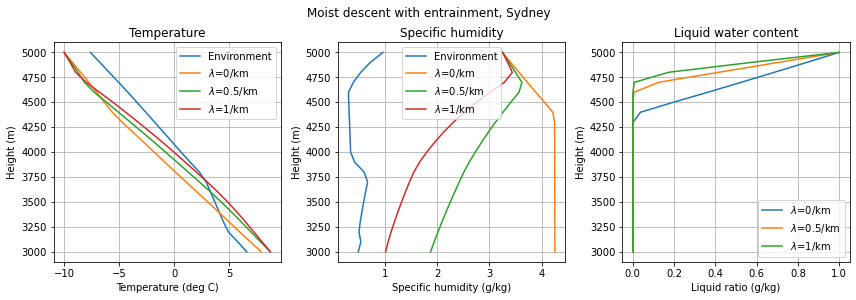

In [349]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
ax.plot(sydney.temperature(height), height, label='Environment')
ax.plot(t1, height, label=r'$\lambda$=0/km')
ax.plot(t2, height, label=r'$\lambda$=0.5/km')
ax.plot(t3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Temperature (deg C)',
    ylabel='Height (m)',
    title='Temperature')

ax = fig.add_subplot(132)
ax.plot(sydney.specific_humidity(height)*1e3, height, label='Environment')
ax.plot(q1*1e3, height, label=r'$\lambda$=0/km')
ax.plot(q2*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(q3*1e3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Specific humidity (g/kg)',
    ylabel='Height (m)',
    title='Specific humidity')

ax = fig.add_subplot(133)
ax.plot(l1*1e3, height, label=r'$\lambda$=0/km')
ax.plot(l2*1e3, height, label=r'$\lambda$=0.5/km')
ax.plot(l3*1e3, height, label=r'$\lambda$=1/km')
ax.legend()
ax.grid()
ax.set(
    xlabel='Liquid ratio (g/kg)',
    ylabel='Height (m)',
    title='Liquid water content')

fig.tight_layout()
fig.suptitle('Moist descent with entrainment, Sydney', y=1.03)
# fig.savefig(
#     fig_path + 'moist_vs_entrainment_rate.png', dpi=300, facecolor='w',
#     bbox_inches='tight')
plt.show()

- The choice of finite difference step size affects the moist part of the desent significantly
    - The apparent moist adiabatic lapse rate increases dramatically at small step sizes

### Moist descent testing: summary
- The finite difference step size has a very significant effect for moist descent (errors up to 30% in final specific humidity). It may be the case that the larger steps give more correct results.
- The size of the integration step is more important for moist descent than dry descent but still less important than the finite difference step.
- Using second order finite differences does change the final specific humidity by ~1%.

## Zero-entrainment case: comparison with expected values
### Dry descent only

In [102]:
height = np.arange(5000, -1, -100)*units.meter
pressure = sydney.pressure(height)
t_initial = -15*units.celsius
q_initial = saturation_specific_humidity(pressure[0], t_initial)

In [108]:
# expected values
result = [
    descend(p, t_initial, q_initial, 0, pressure[0], improve=2)
    for p in pressure]
t_true = concatenate([x[0] for x in result])
q_true = concatenate([x[1] for x in result])
l_true = concatenate([x[2] for x in result])

In [110]:
# entrainment values
t_entr, q_entr, l_entr = entrainment_profile(
    height, t_initial, q_initial, 0, 0/units.km, max_step=200)

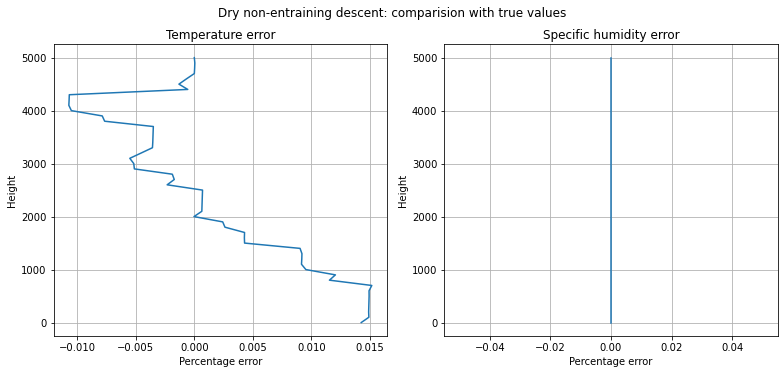

In [120]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)
ax.plot((t_entr - t_true)/t_true*100, height)
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')
ax.grid()
ax = fig.add_subplot(122)
ax.plot((q_entr - q_true)/q_true*100, height)
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')
ax.grid()
fig.tight_layout()
fig.suptitle('Dry non-entraining descent: comparision with true values',
             y=1.03)
plt.show()

### Moist descent

In [121]:
# expected values
result = [
    descend(p, t_initial, q_initial, 5e-3, pressure[0], improve=2)
    for p in pressure]
t_true = concatenate([x[0] for x in result])
q_true = concatenate([x[1] for x in result])
l_true = concatenate([x[2] for x in result])

In [123]:
# entrainment values
t_entr1, q_entr1, l_entr1 = entrainment_profile(
    height, t_initial, q_initial, 5e-3, 0/units.km, max_step=100,
    dz=1*units.meter)
t_entr10, q_entr10, l_entr10 = entrainment_profile(
    height, t_initial, q_initial, 5e-3, 0/units.km, max_step=100,
    dz=10*units.meter)
t_entr50, q_entr50, l_entr50 = entrainment_profile(
    height, t_initial, q_initial, 5e-3, 0/units.km, max_step=100,
    dz=50*units.meter)

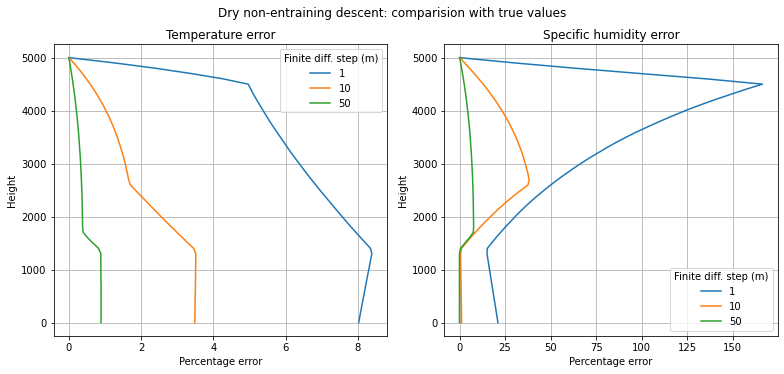

In [125]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121)
ax.plot((t_entr1 - t_true)/t_true*100, height, label='1')
ax.plot((t_entr10 - t_true)/t_true*100, height, label='10')
ax.plot((t_entr50 - t_true)/t_true*100, height, label='50')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Temperature error')
ax.grid()
lgd = ax.legend()
lgd.set_title('Finite diff. step (m)')
ax = fig.add_subplot(122)
ax.plot((q_entr1 - q_true)/q_true*100, height, label='1')
ax.plot((q_entr10 - q_true)/q_true*100, height, label='10')
ax.plot((q_entr50 - q_true)/q_true*100, height, label='50')
ax.set(
    xlabel='Percentage error',
    ylabel='Height',
    title='Specific humidity error')
ax.grid()
lgd = ax.legend()
lgd.set_title('Finite diff. step (m)')
fig.tight_layout()
fig.suptitle('Dry non-entraining descent: comparision with true values',
             y=1.03)
plt.show()

## Next steps

- Get moist descent to converge for small finite difference step
- Test descent with zero entrainment rate against regular calculations
- Knowing temperature as a function of height, calculate buoyancy and solve equation of motion (relatively simple)
- Reversible adiabats?